In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import link_bot_notebooks.toy_problem_optimization_common as tpoc
import open3d as o3d
import numpy as np
import copy

np.set_printoptions(suppress=True, linewidth=200)
plt.style.use('slides')

In [2]:
data=np.load("./data/250_50_sdf_based_collision.npz")
# data=np.load("./data/10000_50_collision.npz")

In [3]:
sdf_data = np.load("./data/obstacles_1_sdf.npz")
res = np.expand_dims(sdf_data['sdf_resolution'], axis=1)
sdf = sdf_data['sdf'].squeeze()
origin = np.expand_dims(np.array(sdf.shape, dtype=np.int32) / 2, axis=1)

In [4]:
actions = data['actions']
states = data['states']
tail = data['states'][:, :, 0:2]
mid = data['states'][:, :, 2:4]
head = data['states'][:, :, 4:6]
constraints = data['constraints']
T = states.shape[1]

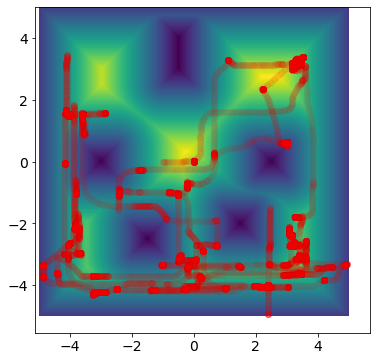

In [5]:
# show all location of the tail overlayed on the SDF
plt.figure(figsize=(6,6))
plt.imshow(np.flipud(sdf.T), extent=[-5,5,-5,5])
plt.scatter(tail[:,:,0], tail[:,:,1], c='r', alpha=0.05)
plt.axis("equal");

In [20]:
# iterate over the data and find the data points which are on the boundary of collision, and take their average
data_at_threshold = []
for state_traj, constraint_traj in zip(states, constraints):
    for t_idx in range(T - 1):
        current_constraint = constraint_traj[t_idx]
        next_constraint = constraint_traj[t_idx + 1]
        # xor operator
        if bool(current_constraint) ^ bool(next_constraint): 
            average_state = (state_traj[t_idx] + state_traj[t_idx + 1]) / 2
            data_at_threshold.append(average_state)
data_at_threshold = np.array(data_at_threshold)

(108, 6)


In [10]:
threshold = 0.2
sdf_points_at_threshold = []
for row, col in np.ndindex(sdf.shape):
    d = sdf[row, col]
    if np.isclose(d, threshold):
        point = tpoc.sdf_idx_to_point(row, col, res, origin)
        sdf_points_at_threshold.append(point)
sdf_points_at_threshold = np.array(sdf_points_at_threshold).squeeze()
np.random.shuffle(sdf_points_at_threshold)

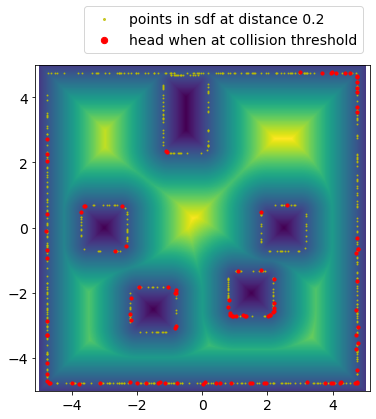

In [12]:
# show all location of the tail overlayed on the SDF
plt.figure(figsize=(6,6))
subsample = 10
plt.imshow(np.flipud(sdf.T), extent=[-5,5,-5,5])
plt.scatter(sdf_points_at_threshold[::subsample,0], sdf_points_at_threshold[::subsample,1], c='y', s=1, alpha=0.8, label='points in sdf at distance {}'.format(threshold))
plt.scatter(data_at_threshold[:,4], data_at_threshold[:,5], c='r', s=10, label='head when at collision threshold')
plt.legend(loc='upper right', bbox_to_anchor=(1.0,1.20))
plt.axis("equal");

In [16]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])
    
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = o3d.geometry.voxel_down_sample(pcd, voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    o3d.geometry.estimate_normals(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

def prepare_dataset(source_xyz, target_xyz, voxel_size):
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(source_xyz)
    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(target_xyz)
    trans_init = np.asarray([[0.0, 0.0],
                             [0.0, 0.0],
                             [0.0, 0.0],
                             [0.0, 0.0],
                             [1.0, 0.0],
                             [0.0, 1.0],
                            ])
    source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

In [26]:
print(data_at_threshold.shape)
print(sdf_points_at_threshold.shape)
# voxel_size = res[0,0]
# source_xyz = data_at_threshold
# target_zs = np.zeros((sdf_points_at_threshold.shape[0], 1))
# target_xyz = np.hstack((sdf_points_at_threshold, target_zs))
# source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(source_xyz, target_xyz, voxel_size)

# distance_threshold = voxel_size * 0.5
# options = o3d.registration.FastGlobalRegistrationOption(maximum_correspondence_distance=distance_threshold)
# result = o3d.registration.registration_fast_based_on_feature_matching(source_down, target_down, source_fpfh, target_fpfh, options)
# print(result)

(108, 6)
(6044, 2)


In [24]:
import icp

In [27]:
A = data_at_threshold
B = sdf_points_at_threshold

T, distances, iterations = icp.icp(B, A, tolerance=0.000001)
print(T

AssertionError: 

In [28]:
s1 = np.array([-0.999943,0.00207,-0.000103,0.019921,0.999871,0.01264]).reshape(3, 2)
s2 = np.array([-1.342023,-3.204006,1.708665,2.295134,0.587233,0.68416]).reshape(3, 2)
pred_u1 = np.array([2.285184,1.505179])

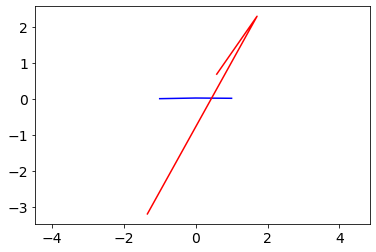

In [30]:
plt.figure()
plt.plot([s1[0,0], s1[1,0], s1[2,0]], [s1[0,1], s1[1,1], s1[2,1]], c='b')
plt.plot([s2[0,0], s2[1,0], s2[2,0]], [s2[0,1], s2[1,1], s2[2,1]], c='r')
plt.axis("equal");

In [ ]:
s3 = np.array([-0.999943,0.00207,-0.000103,0.019921,0.999871,0.01264])
u2 = np.array([2.285184,1.505179])
pred_s4 = np.array([0.037545,0.019141,0.077406,0.026491,0.165744,0.11107])